In [ ]:
import os
import tarfile

if not os.path.isfile('./data.tar.gz'):
    !wget 'http://cs.umd.edu/~pulkit/hw_3_data.tar.gz' -O data.tar.gz

with tarfile.open('./data.tar.gz', 'r:gz') as tar:
    tar.extractall(path='./')


--2024-05-02 21:37:26--  http://cs.umd.edu/~pulkit/hw_3_data.tar.gz
Resolving cs.umd.edu (cs.umd.edu)... 128.8.127.4
Connecting to cs.umd.edu (cs.umd.edu)|128.8.127.4|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www.cs.umd.edu/~pulkit/hw_3_data.tar.gz [following]
--2024-05-02 21:37:26--  http://www.cs.umd.edu/~pulkit/hw_3_data.tar.gz
Resolving www.cs.umd.edu (www.cs.umd.edu)... 128.8.127.4
Reusing existing connection to cs.umd.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 7171530 (6.8M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]   6.84M  5.16MB/s    in 1.3s    

2024-05-02 21:37:28 (5.16 MB/s) - ‘data.tar.gz’ saved [7171530/7171530]



### Dataset class

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import cv2
import os
from PIL import Image
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, csv_path, data_root, transform=None, device='cpu'):
        self.transform = transform
        self.root_path = data_root
        self.device = device

        data = pd.read_csv(csv_path)

        self.image_paths = data["image_path"]

        if "class_id" in data:
            self.class_ids = data["class_id"]
        else:
            self.class_ids = None

        self.image_names = data["image_name"]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        rel_img_path = self.image_paths[idx]
        image_name = self.image_names[idx]

        img = Image.open(self.root_path + rel_img_path)

        img = img.convert("RGB")
        img = transform(img)
        img = img.permute(1,2,0)

        if self.class_ids is None:
            return img, image_name, rel_img_path
        else:
            class_id = torch.tensor(self.class_ids[idx], dtype=torch.long)
            return img.to(self.device), class_id.to(self.device)

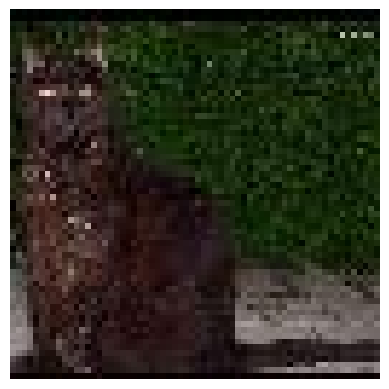

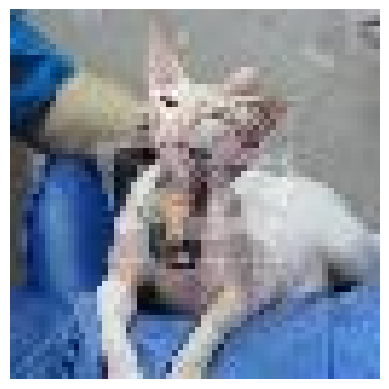

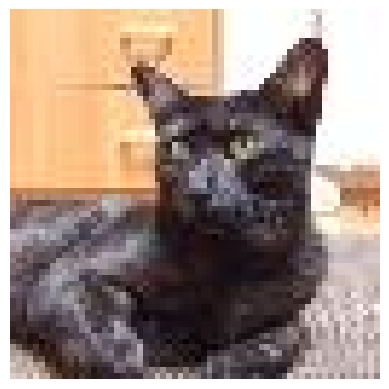

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms as T

def plot_image(img, title=None):
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


transform = T.ToTensor()
dataset = CustomImageDataset("/content/data/csvs/train.csv", "/content/", transform)

img, clas = dataset.__getitem__(0)
plot_image(img)
img, clas = dataset.__getitem__(1)
plot_image(img)
img, clas = dataset.__getitem__(2)
plot_image(img)


### Model definition

Define your image classifier model here. Since we're working with images, you should consider an convolution neural network type model architecture. Start simple and make it more complex if you need to once you have something working.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(4,4))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4,4))
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4,4))
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3))
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.AvgPool2d(2,2)
        self.fc1 = nn.Linear(in_features=6400, out_features=2700)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=2700, out_features=900)
        self.relu6 = nn.ReLU()
        self.fc3 = nn.Linear(900, 200)
        self.relu7 = nn.ReLU()
        self.fc4 = nn.Linear(200, n_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = self.relu5(self.fc1(x))
        x = self.relu6(self.fc2(x))
        x = self.relu7(self.fc3(x))
        return self.fc4(x)

### Training

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
import torchvision.transforms as T
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 16

learning_rate = 1e-4

transform = T.Compose([T.ToTensor(), T.RandomHorizontalFlip(0.2), T.RandomGrayscale(0.1)])

img_root = "./"

train_set = CustomImageDataset("/content/data/csvs/train.csv", "/content/", transform)
val_set = CustomImageDataset("/content/data/csvs/val.csv", "/content/")

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

n_classes = 10
model = ImageClassifier(n_classes=n_classes)

optimizer = Adam(model.parameters(), lr=learning_rate)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

loss_fn = nn.CrossEntropyLoss()

eval_every = 2

n_epochs = 10
val_loss_values = []
training_loss_values = []
eval_epochs = []

for epoch in range(n_epochs):
    model.train()
    for img, label in tqdm(train_loader):
        optimizer.zero_grad()

        img = img.permute(0,3,1,2)
        pred = model(img)

        loss = loss_fn(pred, label)

        loss.backward()
        optimizer.step()

    if epoch > 0 and epoch % eval_every == 0:
        model.eval()
        with torch.no_grad():
            for img, label in tqdm(val_loader):
                img = img.permute(0,3,1,2)
                pred = model(img)
                val_loss = loss_fn(pred, label)

        print(f"Epoch: {epoch}, Train Loss: {loss.item()} Eval Loss: {val_loss.item()}")
        eval_epochs.append(epoch)
        training_loss_values.append(loss.item())
        val_loss_values.append(val_loss.item())

        scheduler.step(val_loss)

torch.save(model.state_dict(), "model.pth")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/188 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 32/32 [00:03<00:00,  8.10it/s]


Epoch: 2, Train Loss: 0.9536120295524597 Eval Loss: 1.1416698694229126


100%|██████████| 32/32 [00:04<00:00,  7.73it/s]


Epoch: 4, Train Loss: 2.4277498722076416 Eval Loss: 1.421586275100708


100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch: 6, Train Loss: 1.4114453792572021 Eval Loss: 1.8815526962280273


100%|██████████| 32/32 [00:04<00:00,  7.68it/s]


Epoch: 8, Train Loss: 0.8649470210075378 Eval Loss: 0.542758584022522


100%|██████████| 188/188 [02:27<00:00,  1.27it/s]


### Training and validation loss

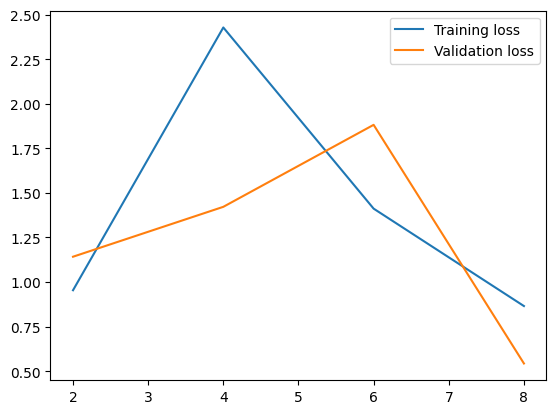

In [ ]:
plt.plot(eval_epochs, training_loss_values, label='Training loss')
plt.plot(eval_epochs, val_loss_values, label='Validation loss')
plt.legend()
plt.show()

### Testing model against the validation dataset

In [ ]:
import numpy as np
import torch

model_state_dict = torch.load("./model.pth")
model = ImageClassifier(n_classes=10)
model.load_state_dict(model_state_dict)

model.eval()
batch_size = 1

test_dataset = CustomImageDataset("/content/data/csvs/val.csv", "/content/")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

preds = []
model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        img = img.permute(0,3,1,2)
        pred = model(img)
        _, predicted = torch.max(pred, 1)
        preds.append(predicted)

true_labels = torch.tensor(test_dataset.class_ids)

accuracy = (true_labels == torch.tensor(preds)).float().mean().item()
print(f"Accuracy: {accuracy}")

  0%|          | 0/500 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 500/500 [00:09<00:00, 52.39it/s]

Accuracy: 0.6000000238418579


### Evaluation

In [ ]:
import numpy as np
import torch

model_state_dict = torch.load("./model.pth")
model = ImageClassifier(n_classes=10)
model.load_state_dict(model_state_dict)

model.eval()

test_dataset = CustomImageDataset("/content/data/csvs/test.csv", "/content/")

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

final_preds = []

with torch.no_grad():
    for img, img_names, img_paths in tqdm(test_loader):
        img = img.permute(0,3,1,2)
        predicted = model(img)
        _, pred = torch.max(predicted, 1)
        batch_preds = [
            (img_name, pred_img.item(), img_path)
            for (img_name, pred_img, img_path) in zip(img_names, pred, img_paths)
        ]
        final_preds.extend(batch_preds)

  0%|          | 0/1500 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1500/1500 [00:29<00:00, 50.91it/s]


In [ ]:
test_prediction = pd.DataFrame(final_preds, columns=['image_name', 'prediction', 'image_path'])
test_prediction.to_csv('prediction.csv')

from google.colab import files
files.download('prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>